# Colab Imports

In [ ]:
from google.colab import drive
from google.colab import userdata
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installation

In [ ]:
!pip -q install langgraph langchain_openai langchain_community tiktoken konlpy

In [ ]:
!pip -q install langgraph langchain_openai langchain_community tiktoken konlpy langchain-pinecone pinecone-notebooks

# Settings & Loadings

In [ ]:
import os
import json
import pandas as pd

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

PROFECT_DIR = os.path.join("/content/drive/MyDrive", "Profect SAE")
CSVs = os.path.join(PROFECT_DIR, "test_data/CSVs")
files = os.listdir(CSVs)
csv_files = [
    file for file in files
      if file.endswith(".csv")
]

df_one = pd.read_csv(os.path.join(CSVs, csv_files[0]))
print(df_one.iloc[0])

title      [종합] 김태희, 해외서 권총 강도 당했다…'연매출 1100억' 정샘물 "피해액 2...
url        https://m.entertain.naver.com/article/312/0000...
content    본문 바로가기 naver 엔터 뉴스 스포츠 사용자 링크 로그인 검색 홈 드라마 영화...
Name: 0, dtype: object


# Models, Schema & State
- `gpt-4o-mini`
- `text-embedding-3-large`

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

In [ ]:
from pydantic import BaseModel, Field
from typing import Optional, List

class RequestDto(BaseModel):
  title: str = Field(..., min_length=1)
  url: str = Field(..., min_length=5, max_length=2083)
  content: str = Field(..., min_length=1)

class ResponseDto(BaseModel):
  korean_name: str
  english_name: str
  ticker_code: str

class FlowState(BaseModel):
  request_dto: RequestDto
  response_dto: List[ResponseDto]
  route: str

# Agents, Nodes & Tools

## Agents
- Preprocessing Flow
  - `preprocessing_routing_agent`
  - `preprocessing_closing_agent`
- Retriever Flow
 - `embedding_agent`
 - `retriever_agent`
    - `retriever_init`
    - `retrieved_vector_parser`

In [ ]:
import re

def preprocessing_routing_agent(state: FlowState):
  request_dto = state.request_dto

  youtube_pattern = r"^https?://(www\.)?youtube\.com"
  naver_news_pattern = r"^https?://n\.news\.naver\.com"
  naver_entertainment_pattern = r"^https?://m\.entertain\.naver\.com"
  naver_sports_pattern = r"^https?://m\.sports\.naver\.com"

  if re.match(naver_news_pattern, request_dto.url):
      route = "naver_news"

  elif re.match(naver_entertainment_pattern, request_dto.url):
      route = "naver_entertainment"

  elif re.match(naver_sports_pattern, request_dto.url):
      route = "naver_sports"

  elif re.match(youtube_pattern, request_dto.url):
      route = "youtube"
  else:
      route = "default"

  # Basic text cleaning

  ## Title
  request_dto.title = text_cleaning(request_dto.title)

  ## Content
  request_dto.content = text_cleaning(request_dto.content)

  # Add route to the requestDto and return as a dictionary
  state.route = route
  return state

In [ ]:
korean_stopwords = [
    "아", "휴", "아이구", "아이쿠", "아이고", "어", "나", "우리", "저희", "따라", "의해", "을", "를", "에", "의", "가",
    "으로", "로", "에게", "뿐이다", "의거하여", "근거하여", "입각하여", "기준으로", "예하면", "예를 들면", "예를 들자면",
    "저", "소인", "소생", "저희", "지말고", "하지마", "하지마라", "다른", "물론", "또한", "그리고", "비길수 없다", "해서는 안된다",
    "뿐만 아니라", "만이 아니다", "만은 아니다", "막론하고", "관계없이", "그치지 않다", "그러나", "그런데", "하지만", "든간에",
    "논하지 않다", "따지지 않다", "설사", "비록", "더라도", "아니면", "만 못하다", "하는 편이 낫다", "불문하고", "향하여",
    "향해서", "향하다", "쪽으로", "틈타", "이용하여", "타다", "오르다", "제외하고", "이 외에", "이 밖에", "하여야",
    "비로소", "한다면 몰라도", "외에도", "이곳", "여기", "부터", "기점으로", "따라서", "할 생각이다", "하려고하다",
    "이리하여", "그리하여", "그렇게 함으로써", "하지만", "일때", "할때", "앞에서", "중에서", "보는데서", "으로써", "로써",
    "까지", "해야한다", "일것이다", "반드시", "할줄알다", "할수있다", "할수있어", "임에 틀림없다", "한다면", "등", "등등",
    "제", "겨우", "단지", "다만", "할뿐", "딩동", "댕그", "대해서", "대하여", "대하면", "훨씬", "얼마나", "얼마만큼",
    "얼마큼", "남짓", "여", "얼마간", "약간", "다소", "좀", "조금", "다수", "몇", "얼마", "지만", "하물며", "또한",
    "그러나", "그렇지만", "하지만", "이외에도", "대해 말하자면", "뿐이다", "다음에", "반대로", "반대로 말하자면",
    "이와 반대로", "바꾸어서 말하면", "바꾸어서 한다면", "만약", "그렇지않으면", "까악", "툭", "딱", "삐걱거리다",
    "보드득", "비걱거리다", "꽈당", "응당", "해야한다", "에 가서", "각", "각각", "여러분", "각종", "각자", "제각기",
    "하도록하다", "와", "과", "그러므로", "그래서", "고로", "한 까닭에", "하기 때문에", "거니와", "이지만", "대하여",
    "관하여", "관한", "과연", "실로", "아니나다를가", "생각한대로", "진짜로", "한적이있다", "하곤하였다", "하", "하하",
    "허허", "아하", "거바", "와", "오", "왜", "어째서", "무엇때문에", "어찌", "하겠는가", "무슨", "어디", "어느곳",
    "더군다나", "하물며", "더욱이는", "어느때", "언제", "야", "이봐", "어이", "여보시오", "흐흐", "흥", "휴", "헉헉",
    "헐떡헐떡", "영차", "여차", "어기여차", "끙끙", "아야", "앗", "아야", "콸콸", "졸졸", "좍좍", "뚝뚝", "주룩주룩",
    "솨", "우르르", "그래도", "또", "그리고", "바꾸어말하면", "바꾸어말하자면", "혹은", "혹시", "답다", "및", "그에 따르는",
    "때가 되어", "즉", "지든지", "설령", "가령", "하더라도", "할지라도", "일지라도", "지든지", "몇", "거의", "하마터면",
    "인젠", "이젠", "된바에야", "된이상", "만큼", "어찌됏든", "그위에", "게다가", "점에서 보아", "비추어 보아", "고려하면",
    "하게될것이다", "일것이다", "비교적", "좀", "보다더", "비하면", "시키다", "하게하다", "할만하다", "의해서", "연이서",
    "이어서", "잇따라", "뒤따라", "뒤이어", "결국", "의지하여", "기대여", "통하여", "자마자", "더욱더", "불구하고",
    "얼마든지", "마음대로", "주저하지 않고", "곧", "즉시", "바로", "당장", "하자마자", "밖에 안된다", "하면된다", "그래",
    "그렇지", "요컨대", "다시 말하자면", "바꿔 말하면", "즉", "구체적으로", "말하자면", "시작하여", "시초에", "이상", "허",
    "헉", "허걱", "바와같이", "해도좋다", "해도된다", "게다가", "더구나", "하물며", "와르르", "팍", "퍽", "펄렁", "동안",
    "이래", "하고있었다", "이었다", "에서", "로부터", "까지", "예하면", "했어요", "해요", "함께", "같이", "더불어", "마저",
    "마저도", "양자", "모두", "습니다", "가까스로", "하려고하다", "즈음하여", "다른", "다른 방면으로", "해봐요", "습니까",
    "했어요", "말할것도 없고", "무릎쓰고", "개의치않고", "하는것만 못하다", "하는것이 낫다", "매", "매번", "들", "모", "어느것",
    "어느", "로써", "갖고말하자면", "어디", "어느쪽", "어느것", "어느해", "어느 년도", "라 해도", "언젠가", "어떤것", "어느것",
    "저기", "저쪽", "저것", "그때", "그럼", "그러면", "요만한걸", "그래", "그때", "저것만큼", "그저", "이르기까지", "할 줄 안다",
    "할 힘이 있다", "너", "너희", "당신", "어찌", "설마", "차라리", "할지언정", "할지라도", "할망정", "할지언정", "년", "월",
    "일", "하나", "둘", "셋", "넷", "다섯", "여섯", "일곱", "여덟", "아홉"
]

In [ ]:
from konlpy.tag import Okt

def preprocessing_closing_agent(state: FlowState):
  requestDto = state.request_dto
  content = requestDto.content
  okt = Okt()
  content_tokens = okt.morphs(content)

  result = [
      word for word in content_tokens
        if not word in korean_stopwords
      ]
  state.request_dto = RequestDto(title=requestDto.title, url=requestDto.url, content=" ".join(result))
  return state

In [ ]:
def embedding_agent(state= FlowState) -> FlowState:
  return state

In [ ]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone
from pydantic import BaseModel
from typing import List
from langchain_openai import OpenAIEmbeddings
import tiktoken

pc = Pinecone(api_key=userdata.get('PINECONE-API-KEY'))

def retrieved_vector_parser(given_vectors):
    return [
        ResponseDto(
            korean_name=vector.metadata.get("korean_name", "N/A"),
            english_name=vector.metadata.get("english_name", "N/A"),
            ticker_code=vector.metadata.get("ticker_code", "N/A")
        )
        for vector in given_vectors
    ]

def retriever_agent(state: FlowState):
  text = f"{state.request_dto.title}  {state.request_dto.content}"
  encoding = tiktoken.get_encoding("cl100k_base")
  print(state.request_dto.title)
  print(len(encoding.encode(text)))

  # Vector Store init
  embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
  kor_retriever = retriever_init("sae-embedded-stocks-kor", embeddings, "kospi-900")
  foriegn_retriever = retriever_init("sae-embedded-stocks-foriegn", embeddings, "nasdaq-1000")

  # Invoke
  kor_result = retrieved_vector_parser(kor_retriever.invoke(text))
  foriegn_result = retrieved_vector_parser(foriegn_retriever.invoke(text))
  state.response_dto.extend(kor_result)
  state.response_dto.extend(foriegn_result)
  return state

def retriever_init(index_name: str, embeddings, namespace):
  index = pc.Index(index_name)
  vector_store = PineconeVectorStore(index=index, embedding=embeddings)
  return vector_store.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 2, "score_threshold": 0.65,"namespace": namespace},)


## Tools
- `text_cleaning`

In [ ]:
from langchain_core.tools import tool

@tool
def text_cleaning(text: str) -> str:
    """Cleaning text by removing unnecessary characters and spaces."""
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove leading and trailing spaces
        text = text.strip()
        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text)
        # Remove special characters except for common ones
        text = re.sub(r'[^\w\s.,!?$%&@()-]', '', text)
    return text

## Nodes
- `naver_news_preprocessing`
- `naver_entertainment_preprocessing`
- `naver_sports_preprocessing`
- `youtube_preprocessing`

In [ ]:
import re


def content_preprocessing(text: str, remove_after: str = None, patterns: list = None) -> str:
  if not isinstance(text, str):
      return text

  if remove_after:
      text = re.sub(fr"{remove_after}.*", "", text, flags=re.IGNORECASE)

  if patterns:
    combined_pattern = "|".join(patterns)
    text = re.sub(combined_pattern, "", text, flags=re.IGNORECASE)

  # Remove excessive whitespace
  text = re.sub(r"\s+", " ", text).strip()

  return text

def preprocessing_naver_news(state: FlowState):
  requestDto = state.request_dto
  """Cleans Naver News content."""
  requestDto.content = content_preprocessing(requestDto.content, remove_after="copyright .*?\. all rights reserved")
  requestDto.content = content_preprocessing(requestDto.content, remove_after="기사 공유하기")
  requestDto.content = content_preprocessing(requestDto.content, patterns = [
          r"본문 바로가기", r"naver", r"뉴스", r"엔터", r"스포츠", r"날씨", r"프리미엄",
          r"사용자 링크", r"로그인", r"서비스", r"더보기", r"검색", r"언론사별", r"정치",
          r"경제", r"사회", r"생활문화", r"it과학", r"세계", r"랭킹", r"신문보기",
          r"오피니언", r"tv", r"팩트체크", r"알고리즘 안내", r"정정보도 모음"])
  return state

def preprocessing_naver_entertainment(state: FlowState):
  requestDto = state.request_dto
  """Cleans Naver Entertainment content."""
  requestDto.content = content_preprocessing(requestDto.content, remove_after="copyright .*?\. all rights reserved")
  requestDto.content = content_preprocessing(requestDto.content, remove_after="기사 공유하기")
  requestDto.content = content_preprocessing(requestDto.content, patterns = [r"본문 바로가기", r"naver", r"엔터", r"뉴스", r"스포츠", r"사용자 링크", r"로그인", r"검색", r"홈", r"드라마", r"영화", r"뮤직", r"연애", r"포토", r"랭킹", r"최신뉴스", r"연재", r"종합"])
  return state

def preprocessing_naver_sports(state: FlowState):
  requestDto = state.request_dto
  """Cleans Naver Sports content."""
  requestDto.content = content_preprocessing(requestDto.content, remove_after="copyright .*?\. all rights reserved")
  requestDto.content = content_preprocessing(requestDto.content, remove_after="기사 공유하기")
  return state

def preprocessing_youtube(state: FlowState):
  requestDto = state.request_dto
  """Cleans YouTube transcript content."""
  requestDto.content = content_preprocessing(requestDto.content, remove_after="더보기")
  requestDto.content = content_preprocessing(requestDto.content, patterns = [r"kr", r"탐색", r"건너뛰기", r"만들기"])
  return state

In [ ]:
def response_parser(state= FlowState) -> FlowState:
  return state

# Flow

In [ ]:
from langgraph.graph import StateGraph, START, END

graph_blueprint = StateGraph(state_schema=FlowState)

# Registring Nodes
## Preprocessing
graph_blueprint.add_node("preprocessing_routing_agent",preprocessing_routing_agent)
graph_blueprint.add_node("preprocessing_naver_news",preprocessing_naver_news)
graph_blueprint.add_node("preprocessing_naver_entertainment",preprocessing_naver_entertainment)
graph_blueprint.add_node("preprocessing_naver_sports",preprocessing_naver_sports)
graph_blueprint.add_node("preprocessing_youtube",preprocessing_youtube)
graph_blueprint.add_node("preprocessing_closing_agent", preprocessing_closing_agent)
## Retriever
graph_blueprint.add_node("embedding_agent", embedding_agent)
graph_blueprint.add_node("retriever_agent", retriever_agent)
graph_blueprint.add_node("response_parser", response_parser)

# Registring edges
# Start
graph_blueprint.add_edge(START, "preprocessing_routing_agent")

graph_blueprint.add_edge("preprocessing_naver_news", "preprocessing_closing_agent")
graph_blueprint.add_edge("preprocessing_naver_entertainment", "preprocessing_closing_agent")
graph_blueprint.add_edge("preprocessing_naver_sports", "preprocessing_closing_agent")
graph_blueprint.add_edge("preprocessing_youtube", "preprocessing_closing_agent")

## Preprocessing -> Retriever
graph_blueprint.add_edge("preprocessing_closing_agent", "embedding_agent")
graph_blueprint.add_edge("embedding_agent", "retriever_agent")
graph_blueprint.add_edge("retriever_agent", "response_parser")

# End
graph_blueprint.add_edge("response_parser", END)

# Conditional Edges
graph_blueprint.add_conditional_edges(
    "preprocessing_routing_agent",
    lambda state: state.route,
    {
        "naver_news": "preprocessing_naver_news",
        "naver_entertainment": "preprocessing_naver_entertainment",
        "naver_sports": "preprocessing_naver_sports",
        "youtube": "preprocessing_youtube",
        "default": "preprocessing_closing_agent",
    }
)

# Compiling
agentic_rag_flow = graph_blueprint.compile()

# Visualization

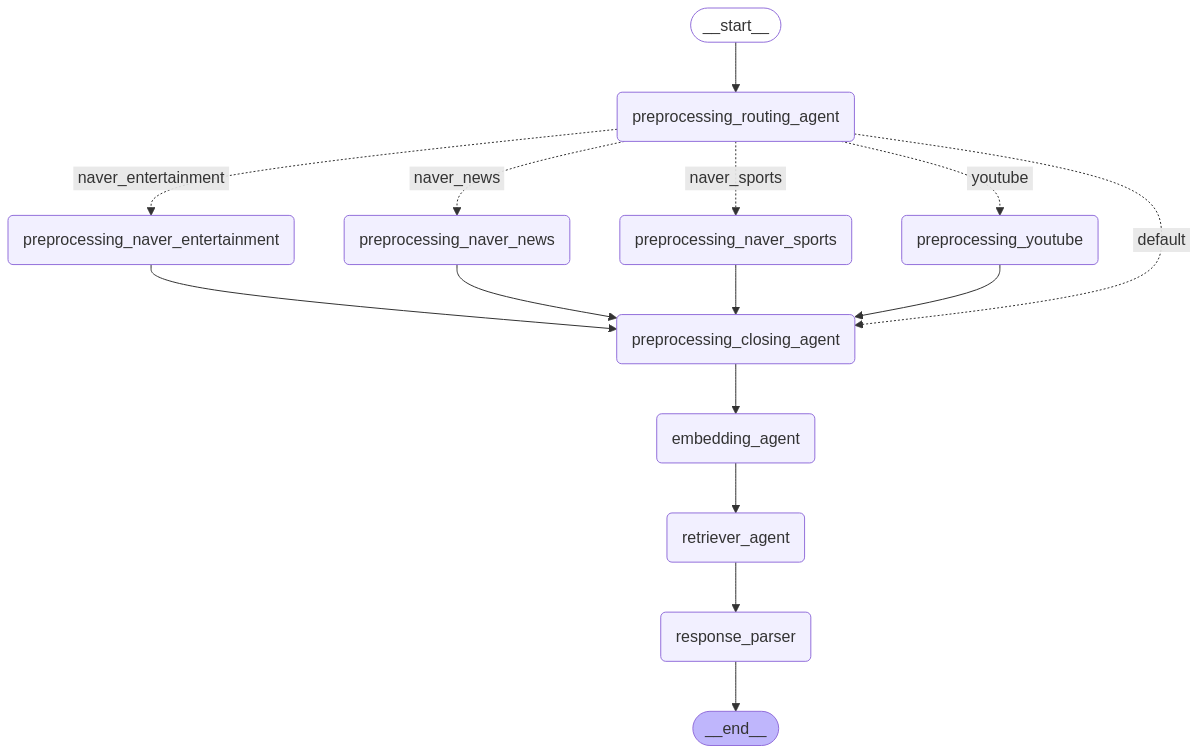

In [ ]:
# Visualize your graph
from IPython.display import Image, display
png = agentic_rag_flow.get_graph().draw_mermaid_png()
display(Image(png))

# Test

In [ ]:
print(len(df_one))

33


In [ ]:
index = 0
for row in df_one.itertuples(index=False):
    request_dto = RequestDto(title=row.title, url=row.url, content=row.content)
    response_dto = []
    flow_state = FlowState(
        request_dto=request_dto,
        response_dto=response_dto,
        route=""
      )
    output = agentic_rag_flow.invoke(flow_state)
    print()
    for stock in output['response_dto']:
      print(stock.korean_name, stock.ticker_code)
    print("----------------------------")
    # if index == 10:
    #     break
    # index += 1

종합 김태희, 해외서 권총 강도 당했다연매출 1100억 정샘물 피해액 2000만원(백억짜리)
1338

티와이홀딩스 363280
한국화장품 123690
헬렌 오브 트로이 HELE
----------------------------
연예계 불화 또 터졌다곽준빈, 유명 여배우에 막말 네가 무슨 배우야 (전현무계획)
1309



IHQ 003560
----------------------------
시우민 뮤뱅 출연 거부 여파..이무진, 리무진서비스 녹화 돌연 불참 스타이슈
1900



----------------------------
우효광 추자현, 폭풍 성장 子와 애틋한 재회..떨어져 지내 힘들었다
1389



----------------------------
이혼숙려캠프 온가족 무직, 생활비 父 유산 2억 다 써 충격
936



----------------------------
與 홍장원 이어 곽종근도 진술 조작 내란 아닌 내란몰이 사기극
2329



----------------------------
안보실장 한미, 대북정책 반드시 사전에 긴밀히 공조하기로
4070

아이마켓코리아 122900
미래에셋증권 006800
모닝스타 MORN
트럼프 미디어 & 테크놀로지 그룹 DJT
----------------------------
선관위 사무총장 특혜 채용 당사자 봐주지 않을것추가 조치 예고
1532



----------------------------
민가 오폭 공군, 모든 항공기 비행 제한조종사 교육 착수
1515



----------------------------
속보 이재명 국민의힘 제안 배우자 상속세 면제폐지 동의
719



----------------------------
한국인들 신라면새우깡 없인 못 사는데가격 오른다
1332



삼양식품 003230
농심 004370
----------------------------
민주 홈플러스 법정관리 일파만파mbk 과도한 탐욕이 원인
1574



현대홈쇼핑 057050
HDC 012630
----------------------------
한국면세점협회 제10대 회장에 김동하 롯데면세점 대표이사
733

롯데쇼핑 023530
롯데지주 004990
스티븐 매든 SHOO
코스트코 홀세일 COST
----------------------------
지난달 선박수주 中 1위韓은 다시 2위로
962

HD한국조선해양 009540
HD현대중공업 329180
골라 LNG GLNG
골든 오션 그룹 GOGL
----------------------------
도시 생활물류 인프라 확충민관 논의 협의체 구성
1056

한진 002320
HMM 011200
트림블 TRMB
사이아 SAIA
----------------------------
skt mwc 전시관에 7만명 몰려ai인프라 슈퍼 하이웨이 체험 인기
1384

SK텔레콤 017670
LG유플러스 032640
인터디지털 IDCC
퀄컴 QCOM
----------------------------
찰나의 순간 변화, 빛으로 실시간 관측발광현상 등 정밀 조작 가능성
1788

솔루스첨단소재 336370
참엔지니어링 009310
펄스 바이오사이언스 PLSE
IPG 포토닉스 IPGP
----------------------------
세계 공략할 비장의 무기는...4300억 벌겠다는 lg유플러스의 포부
1926

LG유플러스 032640
한솔PNS 010420
인터디지털 IDCC
플렉스 FLEX
----------------------------
매달 2650만원 내야한다니...그래도 쓸 사람은 쓴다는 이것
1332

NAVER 035420
템퍼스 AI TEM
엔비디아 NVDA
----------------------------
폴더블 아이폰 나온다는데 가격이애플 마니아도 후덜덜
1512

에이피알 278470
애플 AAPL
앱폴리오 APPF
----------------------------
캐나다, 트럼프 관세 유예에 125조원 규모 2단계 대미 보복관세 연기
1309


트럼프 미디어 & 테크놀로지 그룹 DJT
----------------------------
美우크라, 조만간 실무 회의정상회담 파행 봉합 수순?
1242



----------------------------
트럼프 나토 국가들, 방위비 안 내면 방어 안 할 것
1595



트럼프 미디어 & 테크놀로지 그룹 DJT
----------------------------
딥시크보다 저비용 고성능 ai 모델 내놓은 알리바바 주가 급등
1044

에이피알 278470
타불라 TBLA
바이두 ADR BIDU
----------------------------
트럼프 실세 머스크 반감에 애꿎은 이곳만 불탔다
1586



테슬라 TSLA
트럼프 미디어 & 테크놀로지 그룹 DJT
----------------------------
이정후, 시범경기 2호 홈런 폭발! (feat.현지해설) spotime - youtube
328



----------------------------
뜨거운 열간 단조 기술로 대형 베어링을 만드는 과정. 놀라운 한국의 볼 베어링 공장 - youtube
203

한국특강 007280
대창단조 015230
캠텍 CAMT
----------------------------
일본 귀족이 평가하는 qwer... - youtube
143



----------------------------
휴먼다큐 자식이 좋다 ep.02 엄마라는 이름으로 jamie맘 이소담 씨의 아찔한 라이딩 (20250225 방송) 이수지 핫이슈지 자식이좋다 - youtube
273



----------------------------
국내 최초의 슈퍼카 제조업체(가 될뻔했던) 어울림 모터스에 대해 알아보자 - youtube
198

KR모터스 000040
케이카 381970
폴스타 오토모티브 홀딩 UK ADR PSNY
빈패스트 오토 VFS
----------------------------
불붙은 무역전쟁 미국 최대 25% 관세 시작뉴욕증시-가상화폐 모두 타격  sbs 8뉴스 - youtube
4823



----------------------------
속보오락가락 트럼프 관세 피로감나스닥 2.6%
6455

한국단자 025540
신풍 002870
데이브 DAVE
----------------------------
트럼프 행정부의 관세 정책과 통화 정책 감세와 관세의 상관 관계
3626

F&F홀딩스 007700
SLR 인베스트먼트 SLRC
인터랙티브 브로커스 그룹 IBKR
----------------------------
